In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import glob
import cv2
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lang = {'en': 0, 'nl': 1, 'de': 2, 'ru': 3, 'uk': 4, 'be': 5}

### préparation des données

In [ ]:
def data (langue):
  data = []
  files = glob.glob(f"/content/drive/MyDrive/Projet_RN_M2S1/PROJET-CNN-BAUNE_PITER_TU_MASALSKAYA/data_baseline/{langue}/*")
  print(len(files))
  for i in range(2500):
    data.append(files[i])
  print(len(data))

  return data

In [ ]:
data_en = data("en")
data_nl = data("nl")
data_de = data("de")
data_ru = data("ru")
data_be = data("be")
data_uk = data("uk")

2745
2500
7138
2500
9709
2500
2769
2500
6530
2500
6806
2500


In [ ]:
file_train = []
label_train = []

file_test = []
label_test = []


for data in [data_en, data_be, data_de, data_nl, data_ru, data_uk]:
    print(len(data))
    file_train.extend(data[:1500])
    file_test.extend(data[1500:len(data)])

    if data[0].split("/")[-1].__contains__("en"):
      x = [lang['en']]*1500
      y = [lang['en']]*1000
      label_train.extend(x)
      label_test.extend(y)
    elif data[0].split("/")[-1].__contains__("be"):
      x = [lang['be']]*1500
      y = [lang['be']]*1000
      label_test.extend(y)
      label_train.extend(x)
    elif data[0].split("/")[-1].__contains__("de"):
      x = [lang['de']]*1500
      y = [lang['de']]*1000
      label_test.extend(y)
      label_train.extend(x)
    elif data[0].split("/")[-1].__contains__("nl"):
      x = [lang['nl']]*1500
      y = [lang['nl']]*1000
      label_test.extend(y)
      label_train.extend(x)
    elif data[0].split("/")[-1].__contains__("ru"):
      x = [lang['ru']]*1500
      y = [lang['ru']]*1000
      label_test.extend(y)
      label_train.extend(x)
    elif data[0].split("/")[-1].__contains__("uk"):
      x = [lang['uk']]*1500
      y = [lang['uk']]*1000
      label_test.extend(y)
      label_train.extend(x)

len(file_train), len(file_test), len(label_train), len(label_test)

2500
2500
2500
2500
2500
2500


(9000, 6000, 9000, 6000)

In [ ]:
data_train = []

for path in file_train:
  try :
    image = cv2.imread(path, 0).astype(np.uint8)
    image = cv2.resize(image, (64, 64))
    data_train.append(image)
  except AttributeError :
    continue

len(data_train)

9000

In [ ]:
data_test = []

for path in file_test:
  try :
    image = cv2.imread(path, 0).astype(np.uint8)
    image = cv2.resize(image, (64, 64))
    data_test.append(image)
  except AttributeError :
    continue

### formatage des données au format adapté au modèle

In [ ]:
data_train = np.array(data_train).reshape(-1, 64, 64, 1).astype('float32')/255
data_test = np.array(data_test).reshape(-1, 64, 64, 1).astype('float32')/255
type(data_train), type(data_test)

(numpy.ndarray, numpy.ndarray)

### formatage des labels au format adapté au modèle

In [ ]:
label_train = to_categorical(label_train)
label_test = to_categorical(label_test)
type(label_train), type(label_test)

(numpy.ndarray, numpy.ndarray)

### déclaration du modèle, de ses couches cachées, de ses paramètres et hyperparamètres

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#permet de rajouter de la difficulté en enlevant un quart de filtre à chaque epochs
# évite la surspécialisation
model.add(Dropout(0.5))
#deux couches denses
#met tout à plat sur un vecteur
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))
# FIN -- création des couches

model.summary()

# génération d'un fichier png avec la description des couches de notre modèle
keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [ ]:
early = EarlyStopping(monitor='loss', patience=3)


### entraînement du modèle

In [ ]:
historique = model.fit(data_train, label_train, batch_size=128, epochs=30, verbose=1, callbacks=[early],validation_data=(data_test, label_test))

Epoch 1/30
71/71 [==============================] - 53s 721ms/step - loss: 1.7192 - accuracy: 0.2699 - val_loss: 1.5990 - val_accuracy: 0.3592
Epoch 2/30
71/71 [==============================] - 50s 711ms/step - loss: 1.5076 - accuracy: 0.3941 - val_loss: 1.6079 - val_accuracy: 0.3658
Epoch 3/30
71/71 [==============================] - 56s 797ms/step - loss: 1.4341 - accuracy: 0.4417 - val_loss: 1.5702 - val_accuracy: 0.3915
Epoch 4/30
71/71 [==============================] - 53s 755ms/step - loss: 1.3829 - accuracy: 0.4572 - val_loss: 1.5596 - val_accuracy: 0.4032
Epoch 5/30
71/71 [==============================] - 50s 712ms/step - loss: 1.3506 - accuracy: 0.4684 - val_loss: 1.5308 - val_accuracy: 0.4148
Epoch 6/30
71/71 [==============================] - 50s 709ms/step - loss: 1.3149 - accuracy: 0.4866 - val_loss: 1.5203 - val_accuracy: 0.4172
Epoch 7/30
71/71 [==============================] - 50s 712ms/step - loss: 1.2929 - accuracy: 0.4971 - val_loss: 1.5146 - val_accuracy: 0.4168

In [ ]:
score = model.evaluate(data_test, label_test, verbose=0)
print('test loss: ', score[0])
print('test accuracy: ', score[1])

test loss:  1.6783397197723389
test accuracy:  0.43700000643730164


### prédictions du modèlde

In [ ]:
prediction = model.predict(data_test)
best = np.argmax(prediction, axis=1)
ref = np.argmax(label_test, axis=1)

188/188 [==============================] - 9s 46ms/step


In [ ]:
cm = confusion_matrix(ref, best)
print("Matrice de confusion:\n", cm)

Matrice de confusion:
 [[705  31  64  95  27  78]
 [ 45 586 113 107  75  74]
 [107  97 574 113  49  60]
 [129 132 157 326  97 159]
 [103 216 129 169 127 256]
 [ 75 127 104 273 117 304]]


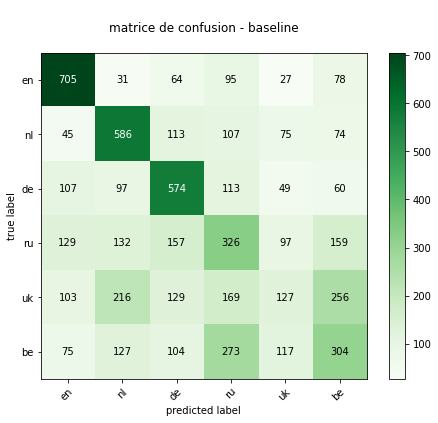

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                class_names=lang.keys(),
                                cmap='Greens',
                                figsize=(8, 6))
plt.title("\nmatrice de confusion - baseline\n")
plt.savefig('matrice_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# !pip uninstall numpy
# !pip uninstall matplotlib
# !pip install numpy
# !pip install matplotlib